### Loading Libraries

In [48]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import glob

### Loading data

In [49]:
# loading all 23 different year rating files
# creating a file path for glob
q = "Data/"+"final*.csv.gz"
# using the file path to create a list
file_list = glob.glob(q)
file_list

['Data\\final_tmbd_data_2000.csv.gz',
 'Data\\final_tmbd_data_2001.csv.gz',
 'Data\\final_tmbd_data_2002.csv.gz',
 'Data\\final_tmbd_data_2003.csv.gz',
 'Data\\final_tmbd_data_2004.csv.gz',
 'Data\\final_tmbd_data_2005.csv.gz',
 'Data\\final_tmbd_data_2006.csv.gz',
 'Data\\final_tmbd_data_2007.csv.gz',
 'Data\\final_tmbd_data_2008.csv.gz',
 'Data\\final_tmbd_data_2009.csv.gz',
 'Data\\final_tmbd_data_2010.csv.gz',
 'Data\\final_tmbd_data_2011.csv.gz',
 'Data\\final_tmbd_data_2012.csv.gz',
 'Data\\final_tmbd_data_2013.csv.gz',
 'Data\\final_tmbd_data_2014.csv.gz',
 'Data\\final_tmbd_data_2015.csv.gz',
 'Data\\final_tmbd_data_2016.csv.gz',
 'Data\\final_tmbd_data_2017.csv.gz',
 'Data\\final_tmbd_data_2018.csv.gz',
 'Data\\final_tmbd_data_2019.csv.gz',
 'Data\\final_tmbd_data_2020.csv.gz',
 'Data\\final_tmbd_data_2021.csv.gz',
 'Data\\final_tmbd_data_2022.csv.gz']

In [50]:
# loading all of the files into one dataframe
df = pd.concat([pd.read_csv(file) for file in file_list])
df.head()

,imdb_id,title,revenue,budget,rating
0,0,NaN,NaN,NaN,NaN
1,tt0113026,The Fantasticks,0.0,10000000.0,NaN
2,tt0113092,For the Cause,0.0,0.0,NaN
3,tt0118694,In the Mood for Love,12854953.0,150000.0,PG
4,tt0118852,Chinese Coffee,0.0,0.0,R


### Exploring and Cleaning dataset

In [51]:
# removing rows where imdb_id is equal to 0 of dataframe
df = df.loc[df['imdb_id'] != 0]

In [52]:
# reviewing value counts of the rating column
df['rating'].value_counts()

R                                  6265
NR                                 3365
PG-13                              3305
PG                                 1471
G                                   449
NC-17                               161
Unrated                               5
-                                     1
UR                                    1
Not Rated                             1
ScreamFest Horror Film Festival       1
R                                     1
PG-13                                 1
10                                    1
Name: rating, dtype: int64

In [53]:
# cleaning up the rating column
# trimming extra spaces to correct errors
df['rating'] = df['rating'].str.strip()
# creating a dictionary to replace odd values
rating_fix = {'UR': 'NR', 'Not Rated': 'NR', 'Unrated': 'NR', '-': 'NR',
             'ScreamFest Horror Film Festival': 'NR', '10': np.nan}
# using replace to apply the dictionary to the column
df['rating'] = df['rating'].replace(rating_fix)
# viewing the results
df['rating'].value_counts()

R        6266
NR       3374
PG-13    3306
PG       1471
G         449
NC-17     161
Name: rating, dtype: int64

In [54]:
# drop na rows from dataframe
print(df.isna().sum())
# drop na
df.dropna(inplace = True)
# checking dataframe
df.isna().sum()

imdb_id        0
title         23
revenue       23
budget        23
rating     22101
dtype: int64


imdb_id    0
title      0
revenue    0
budget     0
rating     0
dtype: int64

## Question #1

## Does the MPAA rating of a movie affect how much revenue the movie generates?

#### 1. Stating Null Hypothesis and Alternate Hypothesis:

- Null Hypothesis: All movies generate similar revenue regardless of rating.
- Alternate Hypothesis: There is a difference in movie revenue depending on rating.

#### 2. Selecting the correct test according to the data type and number of samples:

- The movie revenue is numeric and there are multiple groups (G, PG, PG-13, etc).
- I will use an ANOVA test

#### 3. Test the assumptions of the selected test:

- The assumptions are: No significant outliers, Normality, Equal Variance

#### 4. Execute the selected test, or the alternative test (if the assumptions are not met):

- removed outliers from groups
- none of the groups has a normal distribution, but they have enough samples to proceed
- the groups do not have equal variance. Will use Kruskal-Wallis test

#### 5. Interpreting the p-value (reject or fail to reject your null hypothesis):

- I reject my Null Hypothesis because the p-value was less than .05 and accept my Alternative Hypothesis that there is a difference in revenue based on the different movie ratings.

In [55]:
# Creating different groups for testing
groups = {}
# getting all movie ratings
for n in df['rating'].unique():
    data = df.loc[df['rating'] == n, 'revenue'].copy()
    
    # saving info into the groups dict
    groups[n] = data
# verify that all ratings are keys in the dict
groups.keys()

dict_keys(['PG', 'R', 'G', 'NR', 'PG-13', 'NC-17'])

### Testing Assumptions

#### Check and remove outliers

In [56]:
# checking z scores for outliers
zscore_results = {}

for k, data in groups.items():
    zscores = stats.zscore(data)
    outliers = abs(zscores) > 3
    
    # outliers to a dictionary
    zscore_results[k] = {'outliers': np.sum(outliers)}
    
# creating a dataframe from the dictionary
zscore_results_df = pd.DataFrame(zscore_results).T
zscore_results_df

,outliers
PG,40
R,121
G,10
NR,29
PG-13,89
NC-17,2


In [57]:
# removing outliers from the groups
# loop through all groups and drop outliers
for i, data in groups.items():

    # taking out the outliers
    data = data[(np.abs(stats.zscore(data)) < 3)] 
    
    # saving updated data
    groups[i] = data

#### Assumption of Normality

In [58]:
# completing a normal test on all groups
normal_results = {}
for i, data in groups.items():
    stat, p = stats.normaltest(data)
    normal_results[i] = {'n': len(data), 'p':p, 'test stat': stat}
    
# view the normal results in a dataframe
normal_results_df = pd.DataFrame(normal_results).T
# adding a columns for significant results
normal_results_df['sig'] = normal_results_df['p'] < .05
normal_results_df

,n,p,test stat,sig
PG,1431.0,1.646308e-192,883.195606,True
R,6145.0,0.000000e+00,4652.404221,True
G,439.0,1.836216e-79,362.593031,True
NR,3345.0,0.000000e+00,5597.591002,True
PG-13,3217.0,0.000000e+00,2094.885241,True
NC-17,159.0,5.832796e-46,208.310835,True


All ratings have p-values below 0.05 meaning that I should reject the hypothesis that they are normal. Because all of the ratings have sample sizes larger than 15, I can move on with testing.

#### Assumption of Equal Variance

In [59]:
# using the Levene test to check equal variance
stats.levene(*groups.values())

LeveneResult(statistic=293.57452056691324, pvalue=1.8585839529333962e-300)

The p-value is below 0.05 and I will reject the hypothesis that the groups have equal variance. Because they do not have equal variance I will use the Kruskal-Wallis test.

### Final Test

In [60]:
# using Kruskal-Wallis test
result = stats.kruskal(*groups.values())
result

KruskalResult(statistic=1879.0096566250747, pvalue=0.0)

With a p-value below 0.05 I reject my Null Hypothesis that there is no difference in revenue generated by movies with different ratings. I will accept the Alternative Hypothesis that there is a difference in revenue generated by movie ratings.

### Visualization to support finding

rating
G        3.441080e+07
NC-17    1.133560e+06
NR       1.838002e+06
PG       6.775942e+07
PG-13    7.279976e+07
R        1.614889e+07
Name: revenue, dtype: float64

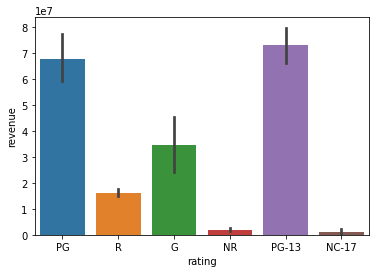

In [61]:
# visualizing the data
sns.barplot(data = df, x = 'rating', y = 'revenue');
# grouping rating my mean revenue
df.groupby('rating')['revenue'].mean()

### Conclusion: Question 1

#### There is a significant difference between revenue generated and movie rating.
- With a p-value of 0 it was clear that different movie ratings generate different revenue
- Movie ratings that generate the most revenue are PG-13 and PG

## Question #2

## Does the genre of a movie affect how much revenue the movie generates?

#### 1. Stating Null Hypothesis and Alternate Hypothesis:

- Null Hypothesis: All movies generate similar revenue regardless of genre.
- Alternate Hypothesis: There is a difference in movie revenue depending on genre.

#### 2. Selecting the correct test according to the data type and number of samples:

- The movie revenue is numeric and there are multiple genres (Family, Adventure, Romance, etc).
- I will use an ANOVA test

#### 3. Test the assumptions of the selected test:

- The assumptions are: No significant outliers, Normality, Equal Variance

#### 4. Execute the selected test, or the alternative test (if the assumptions are not met):

- removed outliers from groups
- none of the groups has a normal distribution, but they have enough samples to proceed
- the groups do not have equal variance. Will use Kruskal-Wallis test

#### 5. Interpreting the p-value (reject or fail to reject your null hypothesis):

- I reject my Null Hypothesis because the p-value was less than .05 and accept my Alternative Hypothesis that there is a difference in revenue based on the different movie ratings. Adventure, Action, Animation, Fantasy and Sci-Fi have the highest earnings.

In [62]:
# loading dataset
basics = pd.read_csv('Data/basics.csv.gz')
basics.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,runtimeMinutes,genres
0,tt0035423,movie,Kate & Leopold,Kate & Leopold,0,2001,118,"Comedy,Fantasy,Romance"
1,tt0062336,movie,The Tango of the Widower and Its Distorting Mi...,El Tango del Viudo y Su Espejo Deformante,0,2020,70,Drama
2,tt0069049,movie,The Other Side of the Wind,The Other Side of the Wind,0,2018,122,Drama
3,tt0088751,movie,The Naked Monster,The Naked Monster,0,2005,100,"Comedy,Horror,Sci-Fi"
4,tt0093119,movie,Grizzly II: Revenge,Grizzly II: The Predator,0,2020,74,"Horror,Music,Thriller"


In [63]:
# merging two dataframes
basics_cols_transfer = ['tconst', 'genres']

q2_df = pd.merge(df, basics[basics_cols_transfer], left_on = ['imdb_id'], right_on=['tconst'])
q2_df.head()

,imdb_id,title,revenue,budget,rating,tconst,genres
0,tt0118694,In the Mood for Love,12854953.0,150000.0,PG,tt0118694,"Drama,Romance"
1,tt0118852,Chinese Coffee,0.0,0.0,R,tt0118852,Drama
2,tt0119273,Heavy Metal 2000,0.0,15000000.0,R,tt0119273,"Action,Adventure,Animation"
3,tt0119495,Love 101,0.0,0.0,R,tt0119495,"Comedy,Drama,Romance"
4,tt0120467,Vulgar,14904.0,120000.0,R,tt0120467,"Crime,Drama,Thriller"


In [64]:
# creating lists of the genres
q2_df['genres_split'] = q2_df['genres'].str.split(',')
q2_df.head()

,imdb_id,title,revenue,budget,rating,tconst,genres,genres_split
0,tt0118694,In the Mood for Love,12854953.0,150000.0,PG,tt0118694,"Drama,Romance","[Drama, Romance]"
1,tt0118852,Chinese Coffee,0.0,0.0,R,tt0118852,Drama,[Drama]
2,tt0119273,Heavy Metal 2000,0.0,15000000.0,R,tt0119273,"Action,Adventure,Animation","[Action, Adventure, Animation]"
3,tt0119495,Love 101,0.0,0.0,R,tt0119495,"Comedy,Drama,Romance","[Comedy, Drama, Romance]"
4,tt0120467,Vulgar,14904.0,120000.0,R,tt0120467,"Crime,Drama,Thriller","[Crime, Drama, Thriller]"


In [65]:
# exploding the genres to separate all unique values
exploded_genres = q2_df.explode('genres_split')
exploded_genres.head()

,imdb_id,title,revenue,budget,rating,tconst,genres,genres_split
0,tt0118694,In the Mood for Love,12854953.0,150000.0,PG,tt0118694,"Drama,Romance",Drama
0,tt0118694,In the Mood for Love,12854953.0,150000.0,PG,tt0118694,"Drama,Romance",Romance
1,tt0118852,Chinese Coffee,0.0,0.0,R,tt0118852,Drama,Drama
2,tt0119273,Heavy Metal 2000,0.0,15000000.0,R,tt0119273,"Action,Adventure,Animation",Action
2,tt0119273,Heavy Metal 2000,0.0,15000000.0,R,tt0119273,"Action,Adventure,Animation",Adventure


In [66]:
# finding number of movies per genre
exploded_genres['genres_split'].value_counts()

Drama         7408
Comedy        4902
Action        3006
Thriller      2943
Horror        2750
Crime         2078
Romance       2068
Adventure     1955
Mystery       1227
Animation      937
Sci-Fi         931
Family         906
Fantasy        887
Biography      618
Music          350
History        336
Sport          293
War            172
Musical        150
Western        131
Adult           45
Reality-TV       3
Name: genres_split, dtype: int64

In [67]:
# genre of reality-tv only has 3 samples and will not meet the size requirement.
# these rows will be dropped
exploded_genres = exploded_genres[exploded_genres['genres_split'] != 'Reality-TV']
exploded_genres = exploded_genres[exploded_genres['genres_split'] != 'Adult']

In [68]:
# Creating different groups for testing
groups = {}
# getting all movie ratings
for n in exploded_genres['genres_split'].unique():
    data = exploded_genres.loc[exploded_genres['genres_split'] == n, 'revenue'].copy()
    
    # saving info into the groups dict
    groups[n] = data
# verify that all ratings are keys in the dict
groups.keys()

dict_keys(['Drama', 'Romance', 'Action', 'Adventure', 'Animation', 'Comedy', 'Crime', 'Thriller', 'Family', 'Musical', 'Mystery', 'Sci-Fi', 'Fantasy', 'Horror', 'Music', 'War', 'History', 'Sport', 'Western', 'Biography'])

### Testing Assumptions

#### Checking for Outliers

In [69]:
# checking z scores for outliers
zscore_results = {}

for k, data in groups.items():
    zscores = stats.zscore(data)
    outliers = abs(zscores) > 3
    
    # outliers to a dictionary
    zscore_results[k] = {'outliers': np.sum(outliers)}
    
# creating a dataframe from the dictionary
zscore_results_df = pd.DataFrame(zscore_results).T
zscore_results_df

,outliers
Drama,103
Romance,52
Action,79
Adventure,50
Animation,25
Comedy,105
Crime,31
Thriller,57
Family,21
Musical,5


In [70]:
# removing outliers from the groups
for i, data in groups.items():

    # taking out the outliers
    data = data[(np.abs(stats.zscore(data)) < 3)] 
    
    # saving updated data
    groups[i] = data

#### Assumption of Normality

In [71]:
# completing a normal test on all groups
normal_results_genres = {}
for i, data in groups.items():
    stat, p = stats.normaltest(data)
    normal_results_genres[i] = {'n': len(data), 'p':p, 'test stat': stat}
    
# view the normal results in a dataframe
normal_results_genres_df = pd.DataFrame(normal_results_genres).T
# adding a columns for significant results
normal_results_genres_df['sig'] = normal_results_genres_df['p'] < .05
normal_results_genres_df

,n,p,test stat,sig
Drama,7305.0,0.000000e+00,5961.004408,True
Romance,2016.0,8.240825e-282,1294.439792,True
Action,2927.0,0.000000e+00,1867.631328,True
Adventure,1905.0,1.133205e-197,906.968427,True
Animation,912.0,2.430908e-118,541.633552,True
Comedy,4797.0,0.000000e+00,3306.216950,True
Crime,2047.0,2.174946e-290,1333.945347,True
Thriller,2886.0,0.000000e+00,2414.298954,True
Family,885.0,1.393060e-143,657.876331,True
Musical,145.0,1.642519e-29,132.557473,True


All genres have p-values below 0.05 meaning that I should reject the hypothesis that they are normal. Because all of the genres have sample sizes larger than 15, I can move on with testing.

#### Assumption of Equal Variance

In [72]:
# using the Levene test to check equal variance
stats.levene(*groups.values())

LeveneResult(statistic=175.46542283490572, pvalue=0.0)

The p-value is below 0.05 and I will reject the hypothesis that the genres have equal variance. Because they do not have equal variance I will use the Kruskal-Wallis test.

### Final Test

In [73]:
# using Kruskal-Wallis test
result = stats.kruskal(*groups.values())
result

KruskalResult(statistic=1516.6626610815113, pvalue=1.16940528556364e-310)

With a p-value below 0.05 I reject my Null Hypothesis that there is no difference in revenue generated by movies with different genres. I will accept the Alternative Hypothesis that there is a difference in revenue generated by movie genres.

Adventure, Action, Animation, Fantasy and Sci-Fi have the highest earnings.

### Visualization to support findings

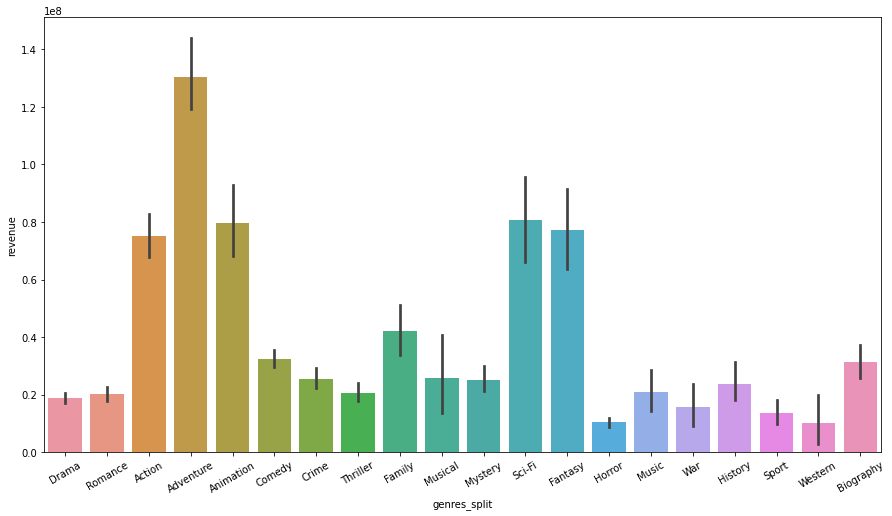

In [74]:
# visualizing the data
plt.figure(figsize = (15,8))
ax = sns.barplot(data = exploded_genres, x = 'genres_split', y = 'revenue')
ax.set_xticklabels(ax.get_xticklabels(),rotation = 30);

In [75]:
# grouping rating my mean revenue
exploded_genres.groupby('genres_split')['revenue'].mean()

genres_split
Action       7.516433e+07
Adventure    1.303632e+08
Animation    7.981969e+07
Biography    3.124282e+07
Comedy       3.241618e+07
Crime        2.556262e+07
Drama        1.874949e+07
Family       4.198679e+07
Fantasy      7.731661e+07
History      2.390950e+07
Horror       1.052934e+07
Music        2.081499e+07
Musical      2.582388e+07
Mystery      2.512277e+07
Romance      2.018652e+07
Sci-Fi       8.066936e+07
Sport        1.383388e+07
Thriller     2.071983e+07
War          1.571318e+07
Western      1.028121e+07
Name: revenue, dtype: float64

## Question #3

## Does a positive rating of a movie affect how much revenue the movie generates?

#### 1. Stating Null Hypothesis and Alternate Hypothesis:

- Null Hypothesis: All movies generate similar revenue regardless of rating.
- Alternate Hypothesis: There is a difference in movie revenue depending on movie rating.

#### 2. Selecting the correct test according to the data type and number of samples:

- The movie revenue is numeric and the rating will be considered positive if 8 or higher.
- I will use an independent t-test

#### 3. Test the assumptions of the selected test:

- The assumptions are: No significant outliers, Normality, Equal Variance

#### 4. Execute the selected test, or the alternative test (if the assumptions are not met):

- removed outliers from groups
- none of the groups has a normal distribution, but they have enough samples to proceed
- the groups do not have equal variance so ensuring equal_var = False in final test.

#### 5. Interpreting the p-value (reject or fail to reject your null hypothesis):

- I reject my Null Hypothesis because the p-value was less than .05 and accept my Alternative Hypothesis that there is a difference in revenue based on a movie rating above 8.

In [76]:
# loading ratings data
ratings_df = pd.read_csv('Data/ratings.csv.gz')
ratings_df.head()

,tconst,averageRating,numVotes
0,tt0000001,5.7,1900
1,tt0000002,5.9,254
2,tt0000003,6.5,1692
3,tt0000004,5.7,166
4,tt0000005,6.2,2509


In [77]:
ratings_df['averageRating'].describe()

count    1.246490e+06
mean     6.915330e+00
std      1.393698e+00
min      1.000000e+00
25%      6.200000e+00
50%      7.100000e+00
75%      7.900000e+00
max      1.000000e+01
Name: averageRating, dtype: float64

In [78]:
# creating a new column to label all highly rated movies
ratings_df['positive_rating'] = ratings_df['averageRating'].apply(lambda x: True if x >= 8 else False)
ratings_df.head()

,tconst,averageRating,numVotes,positive_rating
0,tt0000001,5.7,1900,False
1,tt0000002,5.9,254,False
2,tt0000003,6.5,1692,False
3,tt0000004,5.7,166,False
4,tt0000005,6.2,2509,False


In [79]:
ratings_cols_transfer = ['tconst', 'averageRating', 'positive_rating']

q3_df = pd.merge(df, ratings_df[ratings_cols_transfer], left_on = ['imdb_id'], right_on=['tconst'])
q3_df.head()

,imdb_id,title,revenue,budget,rating,tconst,averageRating,positive_rating
0,tt0118694,In the Mood for Love,12854953.0,150000.0,PG,tt0118694,8.1,True
1,tt0118852,Chinese Coffee,0.0,0.0,R,tt0118852,7.1,False
2,tt0119273,Heavy Metal 2000,0.0,15000000.0,R,tt0119273,5.3,False
3,tt0119495,Love 101,0.0,0.0,R,tt0119495,5.1,False
4,tt0120467,Vulgar,14904.0,120000.0,R,tt0120467,5.2,False


In [80]:
# drop rows where revenue is 0
q3_df = q3_df[q3_df['revenue'] != 0]

In [81]:
q3_df['positive_rating'].value_counts()

False    4996
True      147
Name: positive_rating, dtype: int64

In [82]:
# filtering out ratings above 8 and below
above_df = q3_df[q3_df['positive_rating'] == True].copy()
below_df = q3_df[q3_df['positive_rating'] == False].copy()

In [83]:
# getting revenue
above_revenue = above_df['revenue']
below_revenue = below_df['revenue']

### Testing Assumptions

#### check for and remove outliers

In [84]:
# checking for outliers in the above group
zscores = stats.zscore(above_revenue)
outliers = abs(zscores) > 3
np.sum(outliers)

3

In [85]:
# removing outliers from the above group
above_revenue = above_revenue[(np.abs(stats.zscore(above_revenue)) < 3)]

In [86]:
# checking for outliers in the below group
zscores = stats.zscore(below_revenue)
outliers = abs(zscores) > 3
np.sum(outliers)

128

In [87]:
# removing outliers from the below group
below_revenue = below_revenue[(np.abs(stats.zscore(below_revenue)) < 3)]

#### Assumption of Normality

In [88]:
# testing above group for normality
result_above_revenue = stats.normaltest(above_revenue)
result_above_revenue

NormaltestResult(statistic=45.625298904450354, pvalue=1.237633981792485e-10)

In [89]:
# testing below group for normality
result_below_revenue = stats.normaltest(below_revenue)
result_below_revenue

NormaltestResult(statistic=2557.4735310840347, pvalue=0.0)

Both groups have p-values less than 0.05 and I will reject the hypothesis that they have normal distributions. Because they have sample sizes large enough, the test will continue.

#### Assumption of Equal Variance

In [90]:
# checking for equal variance
result = stats.levene(above_revenue, below_revenue)
result

LeveneResult(statistic=422.74593744911226, pvalue=2.9878970674417e-90)

With a p-value well below 0.05 we do not have equal variance. I will continue the test using equal_var = False.

### Final Test

In [91]:
# preforming independent t-test with equal variance set to false
result = stats.ttest_ind(above_revenue, below_revenue, equal_var = False)
result

Ttest_indResult(statistic=7.467170413418244, pvalue=7.248296666930409e-12)

With the p-value below 0.05 there is a significant difference found. I will reject the hypothesis that there is not a difference in revenue generated between movies with high and low ratings. There is a difference.

### Visualization of findings

In [92]:
# creating a single dataset with final information

positive = pd.DataFrame(above_revenue)
positive["rating"] = True

negative = pd.DataFrame(below_revenue)
negative['rating'] = False

q3_final_df = pd.concat([positive, negative], axis = 0)
q3_final_df.head()

,revenue,rating
0,12854953.0,True
85,465361176.0,True
103,7390108.0,True
206,83557872.0,True
213,39723096.0,True


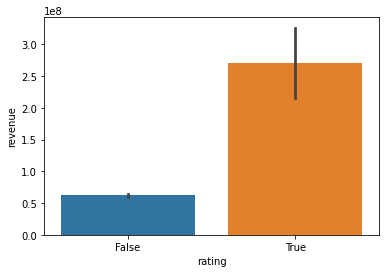

In [93]:
sns.barplot(data = q3_final_df, x = 'rating', y = 'revenue');

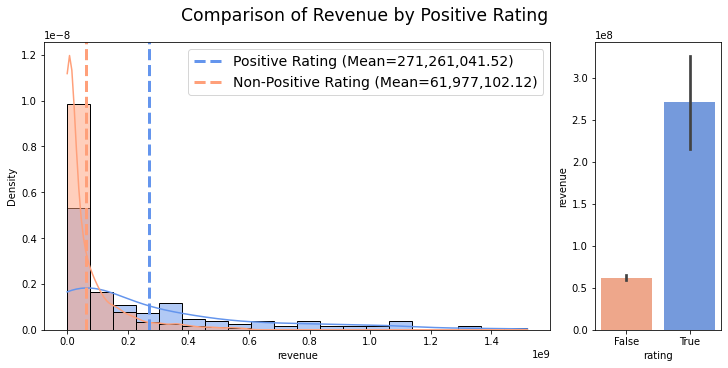

In [94]:
# Adapting the code from the lesson "Intro to T-Tests" to create a visualization

rating_palette={True:'cornflowerblue', False:'lightsalmon'}
# Creating base for plots to live
fig, (ax,ax_bar) = plt.subplots(figsize= (10,5), ncols=2, 
                                constrained_layout=True,
                                gridspec_kw={'width_ratios':[0.8,0.2]})


# Histogram
ax = sns.histplot(data=q3_final_df, x='revenue',bins = 20, fill=True,hue='rating',kde=True,
                  stat='density',
                  common_norm=False,ax=ax,
                  palette=rating_palette)

ax.axvline(np.mean(above_revenue), ls='--',lw=3, 
           label=f"Positive Rating (Mean={np.mean(above_revenue):,.2f})",color=rating_palette[True])

ax.axvline(np.mean(below_revenue), ls='--', lw=3, 
           label=f"Non-Positive Rating (Mean={np.mean(below_revenue):,.2f})",color=rating_palette[False])

ax.legend(prop={"size":14}, loc='upper right')
## Barplot
sns.barplot(data=q3_final_df, x='rating',y='revenue',ax = ax_bar,palette=rating_palette)
fig.suptitle('Comparison of Revenue by Positive Rating',fontsize='xx-large');